In [134]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestRegressor
import numpy as np

**County Level Census Data: https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2017_county_data.csv**

In [136]:
acs_census = pd.read_csv("data/acs2017_county_data.csv")
acs_census = acs_census.rename(columns={x:x.lower() for x in acs_census.columns})
acs_census = acs_census.rename(columns={"countyid":"fips"})
acs_census.county = acs_census.county.apply(lambda x: x.split('County')[0].rstrip())
acs_census.columns

Index(['fips', 'state', 'county', 'totalpop', 'men', 'women', 'hispanic',
       'white', 'black', 'native', 'asian', 'pacific', 'votingagecitizen',
       'income', 'incomeerr', 'incomepercap', 'incomepercaperr', 'poverty',
       'childpoverty', 'professional', 'service', 'office', 'construction',
       'production', 'drive', 'carpool', 'transit', 'walk', 'othertransp',
       'workathome', 'meancommute', 'employed', 'privatework', 'publicwork',
       'selfemployed', 'familywork', 'unemployment'],
      dtype='object')

**County Level COVID Data: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv**

In [108]:
covid_by_county = pd.read_csv("data/covid-us-counties.csv")
covid_by_county.date = pd.to_datetime(covid_by_county.date, format="%Y-%m-%d")
covid_by_county = covid_by_county[covid_by_county['fips'] > 0]
covid_by_county.fips = covid_by_county.fips.astype(int)
covid_by_county

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0
...,...,...,...,...,...,...
51164,2020-04-11,Sublette,Wyoming,56035,1,0
51165,2020-04-11,Sweetwater,Wyoming,56037,7,0
51166,2020-04-11,Teton,Wyoming,56039,53,0
51167,2020-04-11,Uinta,Wyoming,56041,4,0


**Combine Census and COVID Datasets**

In [109]:
# merge on latest date
covid_and_census = pd.merge(covid_by_county[covid_by_county.date == '2020-04-11'], acs_census, on=('county', 'state', 'fips'), 
                  how = 'inner')

**What is correlated with number of cases on 4/11/2020?**

In [110]:
covid_and_census.corr().style.background_gradient(cmap='magma')

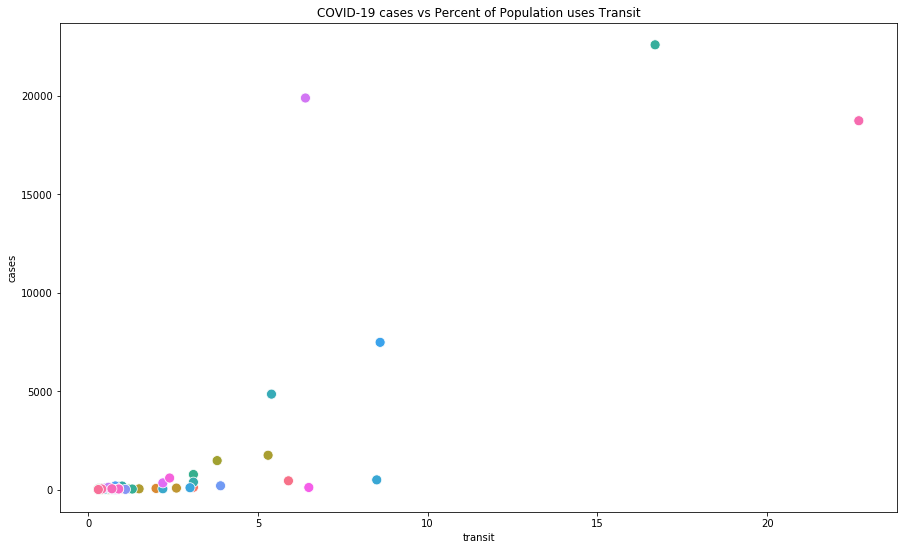

In [111]:
plt.figure(figsize=(15,9))
plt.title('COVID-19 cases vs Percent of Population uses Transit')
splot = sns.scatterplot(x="transit", y="cases", hue="county", s=100, legend=False, data=covid_and_census[covid_and_census.state == "New York"])
plt.show()

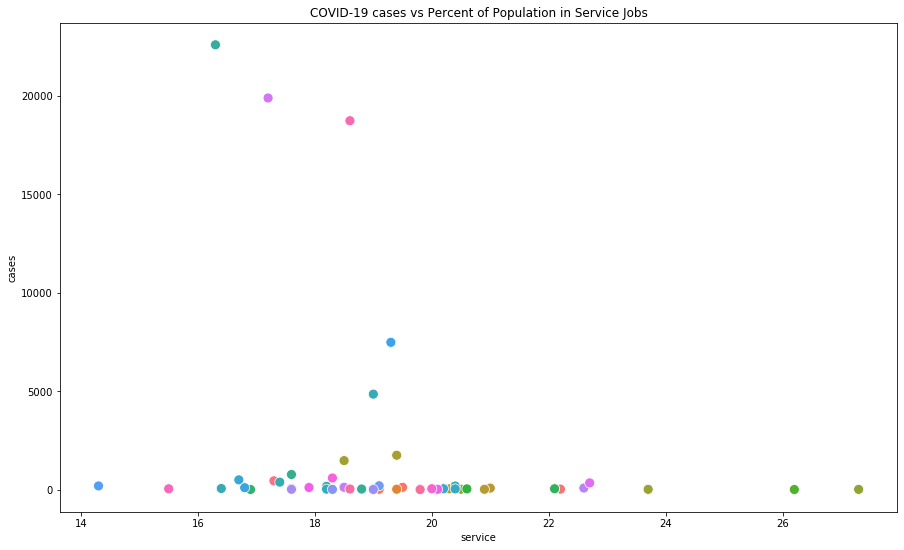

In [112]:
plt.figure(figsize=(15,9))
plt.title('COVID-19 cases vs Percent of Population in Service Jobs')
splot = sns.scatterplot(x="service", y="cases", hue="county", s=100, legend=False, data=covid_and_census[covid_and_census.state == "New York"])
plt.show()

**Let's look at counties where spread is linear over past 20 days**

In [124]:
start = datetime.datetime(2020,3,22)
end = datetime.datetime(2020,4,11)
last20days = covid_by_county[(covid_by_county.date >= start) & (covid_by_county.date <= end)]
# Convert dates to integers to get correlation
numeric_datetimes = pd.to_numeric(last20days.date)
last20days.date = numeric_datetimes
corr_last20days = last20days.groupby('fips')[['date','cases']].corr().iloc[0::2,-1].fillna(0)

In [139]:
# Fips in linear regime
linear_last_20_days = corr_last20days[corr_last20days > 0.95]
# Get fips codes for counties in linear regime
target_fips = linear_last_20_days.reset_index(level=[1]).index
linear_counties_last_20days = last20days[last20days.fips.isin(target_fips)]
linear_counties_last_20days = linear_counties_last_20days.sort_values(by=['date'])
linear_last_20_days.shape
acs_census.shape

(3220, 37)

In [126]:
# Calculate total new cases over past 20 days
datetimes = pd.to_datetime(linear_counties_last_20days.date)
linear_counties_last_20days.date = datetimes
firstlast = linear_counties_last_20days.groupby('fips').agg(['first','last'])
cases_per_day = (firstlast['cases'].iloc[:,1]-firstlast['cases'].iloc[:,0])

In [127]:
# merge series with census
census_with_cases_in_last20 = pd.merge(cases_per_day.rename('cases_last20'), acs_census, 
                                     on=('fips'), how = 'inner')
census_with_cases_in_last20

,fips,cases_last20,state,county,totalpop,men,women,hispanic,white,black,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,1001,18,Alabama,Autauga,55036,26899,28137,2.7,75.4,18.9,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,64,Alabama,Baldwin,203360,99527,103833,4.4,83.1,9.5,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1007,11,Alabama,Bibb,22580,12251,10329,2.4,74.6,22.0,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
3,1009,11,Alabama,Blount,57667,28490,29177,9.0,87.4,1.5,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9
4,1017,182,Alabama,Chambers,33895,16320,17575,2.2,56.2,39.3,...,0.6,0.5,2.0,23.6,14527,84.5,11.8,3.7,0.0,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,56021,52,Wyoming,Laramie,97031,49218,47813,14.3,79.1,2.6,...,2.6,1.5,3.8,15.8,47243,68.2,26.2,5.3,0.3,5.3
1155,56025,31,Wyoming,Natrona,81023,41061,39962,8.2,87.0,1.2,...,1.6,1.1,3.6,17.2,41467,79.3,14.7,5.6,0.4,5.1
1156,56033,8,Wyoming,Sheridan,29964,14816,15148,4.2,91.6,0.9,...,3.3,0.7,5.6,16.0,14663,71.3,22.1,6.3,0.2,3.1
1157,56037,6,Wyoming,Sweetwater,44527,22981,21546,16.0,79.6,0.8,...,2.8,1.3,1.5,20.5,22739,78.4,17.8,3.8,0.0,5.2


**Are correlations any different for counties in linear regime?**

In [128]:
census_with_cases_in_last20.corr().style.background_gradient(cmap='magma')

**Can we predict number of cases over last 20 days based on types of jobs?**

In [129]:
features_df = census_with_cases_in_last20[['office', 'construction', 'production', 'drive', 'carpool', 
                                         'transit','walk', 'othertransp', 'workathome', 'meancommute',
                                         'privatework', 'publicwork', 'selfemployed','cases_last20']]

features_copy = features_df.copy()
# 75% train
train_set = features_copy.sample(frac=0.75)
# 25% test
test_set = features_copy.drop(train_set.index)

In [130]:
target = train_set.pop('cases_last20')
test_target = test_set.pop('cases_last20')

In [131]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_set, target);

In [132]:
print("Model Accuracy (Training): {}".format(rf.score(train_set, target)))
print("Model Accuracy (Testing): {}".format(rf.score(test_set, test_target)))

Model Accuracy (Training): 0.893439621910235
Model Accuracy (Testing): 0.437419616753394


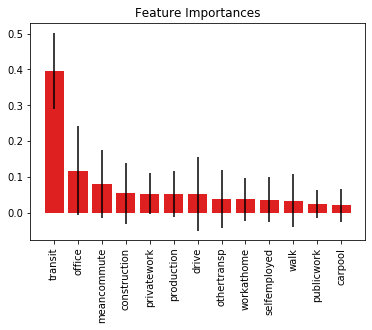

In [133]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")
#for f in range(train_set.shape[1]):
#    print("{}. feature {} ({})".format(f + 1, train_set.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances")
sns.barplot(list(range(train_set.shape[1])), importances[indices],
       color="r", yerr=std[indices])
plt.xticks(range(train_set.shape[1]), indices)
labels = [train_set.columns[indices[f]] for f in range(train_set.shape[1])]
plt.xticks(range(train_set.shape[1]), labels, rotation=90)
plt.xlim([-1, train_set.shape[1]])
plt.show()